In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from math import factorial, exp
from tqdm import tqdm
from collections import Counter
import matplotlib.dates as mdates
from statsmodels.distributions.empirical_distribution import ECDF
import ast  # 문자열을 리스트로 safely 변환하는 모듈


# 1. Load daily confirmed cases, delay
final = pd.read_csv('delay_list.csv')
final['date']=pd.to_datetime(final['date'],errors='coerce')

# 문자열을 리스트로 안전하게 변환
final['delay_list'] = final['delay_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

#delay모으기
total_delay_list= []

for idx, rows in final.iterrows():
    tmp = rows.delay_list
    total_delay_list += tmp


# 1. Load daily confirmed cases, from ourworld in data
serial_interval = pd.read_csv('seiral_interval.csv')


data = serial_interval[(serial_interval['serial_interval'] >0) & (serial_interval['serial_interval'] <= 14)]['serial_interval'].tolist()
shape, loc, scale = gamma.fit(data, floc=False)

def fitted_gamma_pdf(x):
    return gamma.pdf(x, shape, loc=0, scale=scale)

def fitted_gamma_cdf(x):
    return gamma.cdf(x, shape, loc=0, scale=scale)


gi_pdf = fitted_gamma_pdf
gi_cdf = fitted_gamma_cdf



infectious_days = shape * scale
std_dev = np.sqrt(shape) * scale
coefficient_of_variation = std_dev / infectious_days


print("Mean of gamma distributions:", round(infectious_days,3))
print("Standard deviation of gamma distributions:", round(std_dev,3))
print("coefficient of variation of gamma distributions:", round(coefficient_of_variation,3))




FileNotFoundError: [Errno 2] No such file or directory: 'delay_list.csv'

In [1]:
serial_interval

NameError: name 'serial_interval' is not defined

In [81]:
def cal_f(li):
    ecdf_func = ECDF(li)             # ECDF 객체 생성
    def complement(x):               # ECDF 보완 함수 정의
        return 1 - ecdf_func(x)      # 각 x에 대해 1 - F(x)
    return complement

def compute_gi(delay_list, gi_pdf_func, max_lag=20):
    """
    delay_list: 특정 날짜의 delay 리스트 (e.g. [14, 10, 8, ...])
    gi_pdf_func: gi_pdf() 함수
    max_lag: generation interval 최대 일 수
    """
    fi_func = cal_f(delay_list)  # 보완 누적 분포 함수 f_i(t, t')
    
    # fi(t,t') * g*(t') 계산
    weighted_vals = []
    for t_dash in range(max_lag):  # t' = 0 to max_lag-1
        fi = fi_func(t_dash)
        gi = gi_pdf(t_dash)
        weighted_vals.append(fi * gi)
    
    weighted_vals = np.array(weighted_vals)
    si = weighted_vals.sum() if weighted_vals.sum() > 0 else 1e-8  # 정규화 상수 (0 방지)
    gi_vals = weighted_vals / si  # g_i(t', t)
    
    return si, gi_vals  # 길이 max_lag짜리 배열

In [82]:
max_lag = 20
new_cases_arr = final['new_cases'].fillna(0).values  # 관측 확진자 수 N(t')
# I_local = []  # 감염력 I(t)
si_li=[]
gi_vals_li = []

for idx in range(len(final)):
    if idx < max_lag:
        # I_local.append(np.nan)  # 누적 lag 부족한 경우는 제외
        si_li.append(np.nan)
        gi_vals_li.append(np.nan)
        continue
    
    # 1. t시점에 해당하는 delay_list 사용
    delay_list = final.loc[idx, 'delay_list']
    
    if len(delay_list)<7: #149개는 토탈값사용
        delay_list = total_delay_list

    # 2. g_i(t', t) 계산
    si ,gi_vals = compute_gi(delay_list, gi_pdf_func=gi_pdf, max_lag=max_lag)
    
    # 3. 해당 시점에서 lag 적용된 확진자 수 추출
    Ni_t_dash = new_cases_arr[idx - max_lag: idx]  # t' = t-max_lag ~ t-1
    Ni_t_dash = Ni_t_dash[::-1]  # t' = 0이 가장 과거니까 순서 맞춰줌
    
    # 4. 가중치 합
    I_val = np.sum(gi_vals * Ni_t_dash)
    # I_local.append(I_val)
    si_li.append(si)
    gi_vals_li.append(gi_vals.tolist())  # 리스트 형태로 저장


final['gi_vals'] = gi_vals_li
# final['infectiousness']=I_local
final['D_t']=si_li
final

,date,delay_list,new_cases,gi_vals,D_t
0,2020-02-01,[14.0],1.0,NaN,NaN
1,2020-02-04,[8.0],1.0,NaN,NaN
2,2020-02-10,"[12.0, 16.0, 9.0]",1.0,NaN,NaN
3,2020-02-13,"[15.0, 15.0]",0.0,NaN,NaN
4,2020-02-14,"[23.0, 21.0]",0.0,NaN,NaN
...,...,...,...,...,...
650,2022-01-09,"[25.0, 9.0, 10.0, 7.0, 7.0, 6.0, 6.0]",3003.0,"[0.0, 0.12262026888965401, 0.19409523170526213...",0.827346
651,2022-01-24,[10.0],8563.0,"[0.0, 0.11210471161292487, 0.17741800648903766...",0.904296
652,2022-01-31,"[9.0, 16.0, 12.0, 12.0]",18341.0,"[0.0, 0.11210471161292487, 0.17741800648903766...",0.904296
653,2022-12-30,[13.0],63104.0,"[0.0, 0.11210471161292487, 0.17741800648903766...",0.904296


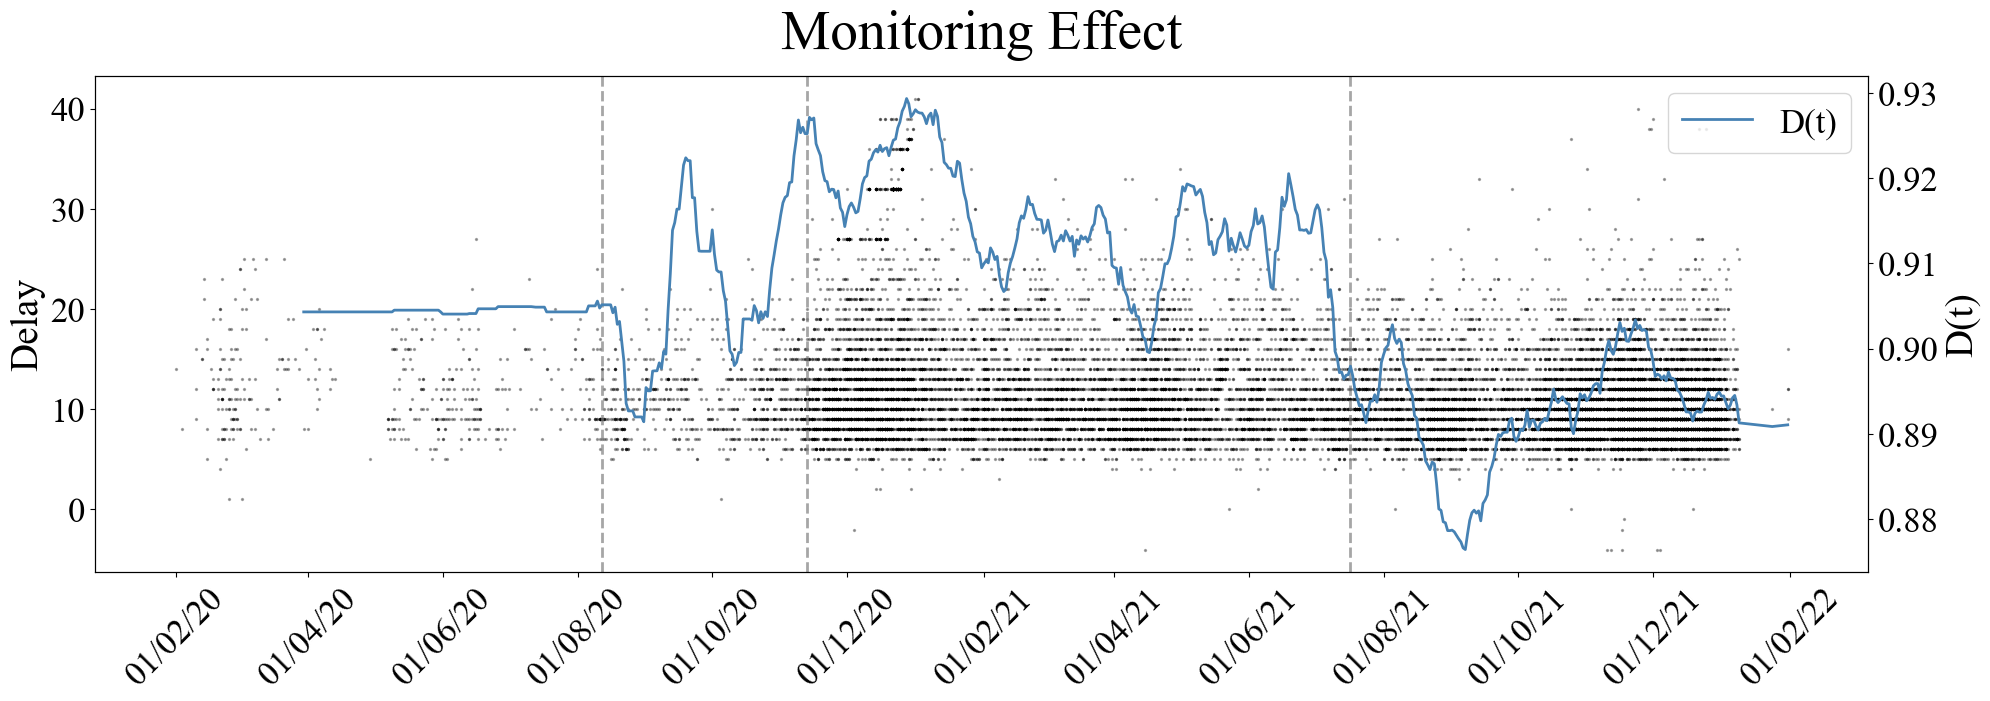

In [83]:
plt.rcParams['font.family'] = 'Times New Roman'

# 날짜 기준 필터링
cutoff_date = pd.to_datetime("2022-01-31")
filtered_final = final[final['date'] <= cutoff_date].copy()

# delay_list explode
expanded_df = filtered_final[['date', 'delay_list']].dropna().explode('delay_list')
expanded_df['delay_list'] = expanded_df['delay_list'].astype(float)

# delay 길이 계산
filtered_final['delay_len'] = filtered_final['delay_list'].apply(lambda x: len(x) if isinstance(x, list) else 0)
filtered_final['D_t_roll'] = filtered_final['D_t'].rolling(21).mean()

# 시각화
fig, ax = plt.subplots(figsize=(20, 7))

# delay 산점도
ax.scatter(expanded_df['date'], expanded_df['delay_list'], s=2, alpha=0.3, color='black')
ax.set_ylabel('Delay', fontsize=28)
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)

# D(t) plot (rolling)
ax2 = ax.twinx()
ax2.plot(filtered_final['date'], filtered_final['D_t_roll'], color='steelblue', linewidth=2, label='D(t)')
ax2.set_ylabel('D(t)', fontsize=28)
ax2.tick_params(axis='y', labelsize=25)

# 중요 시점 표시
important_dates = ['2020-08-12', '2020-11-13', '2021-07-17']
for date in important_dates:
    ax.axvline(pd.to_datetime(date), color='grey', linestyle='--', linewidth=2, alpha=0.7)

# 날짜 포맷 정리
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%y'))  # Jan 2020, Mar 2020, ...
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# 범례
ax2.legend(loc='upper right', fontsize=25)

# 제목 & 레이아웃
plt.title('Monitoring Effect', fontsize=40, pad=20)
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # 제목이 잘리는 경우 대비

plt.show()


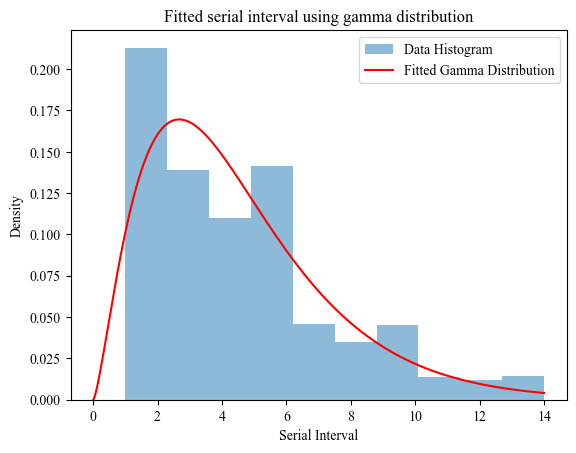

In [84]:
# Plot fitted serial interval using gamma distribution

x = np.linspace(0, 14, 1000)
plt.hist(data, density=True, alpha=0.5, label='Data Histogram')
plt.plot(x, gamma.pdf(x, shape, loc=0, scale=scale), 'r-', label='Fitted Gamma Distribution')

plt.xlabel('Serial Interval')
plt.ylabel('Density')
plt.title('Fitted serial interval using gamma distribution')
plt.legend()
plt.show()